In [3]:
import os, time, json, gc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# -------------------
# Dataset setup
# -------------------
DATA_ROOT = r"C:\Akshi Personal\SmartVision AI\smartvision_dataset\classification"

TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

CLASS_NAMES = [
    'person','bicycle','car','motorcycle','airplane','bus','train','truck',
    'traffic light','stop sign','bench','bird','cat','dog','horse','cow',
    'elephant','bottle','cup','bowl','pizza','cake','chair','couch','potted plant','bed'
]
NUM_CLASSES = len(CLASS_NAMES)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Load datasets
train_ds = keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=CLASS_NAMES, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=True, seed=SEED
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    VAL_DIR, labels='inferred', label_mode='categorical',
    class_names=CLASS_NAMES, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=CLASS_NAMES, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch for performance
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

c:\Users\Akshiya George\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Found 4550 files belonging to 26 classes.
Found 962 files belonging to 26 classes.
Found 988 files belonging to 26 classes.


In [4]:
# -------------------
# Utilities
# -------------------
def build_head(num_classes=NUM_CLASSES, dropout=0.4, bn=True, name="cls_head"):
    head = keras.Sequential(name=name)
    head.add(layers.GlobalAveragePooling2D())
    if bn: head.add(layers.BatchNormalization())
    head.add(layers.Dropout(dropout))
    head.add(layers.Dense(256, activation='relu'))
    if bn: head.add(layers.BatchNormalization())
    head.add(layers.Dropout(dropout))
    head.add(layers.Dense(num_classes, activation='softmax'))
    return head

def compile_model(model, lr=1e-3):
    metrics = [
        keras.metrics.CategoricalAccuracy(name="acc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.TopKCategoricalAccuracy(k=5, name="top5")
    ]
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="categorical_crossentropy", metrics=metrics)
    return model

def callbacks(model_name):
    return [
        keras.callbacks.ModelCheckpoint(f"best_{model_name}.keras", monitor="val_acc", save_best_only=True),
        keras.callbacks.EarlyStopping(monitor="val_acc", patience=8, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)
    ]


In [5]:

# -------------------
# Model builders
# -------------------
def build_vgg16():
    base = keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
    base.trainable = False
    inputs = keras.Input(shape=IMG_SIZE+(3,))
    x = keras.applications.vgg16.preprocess_input(inputs)
    x = base(x, training=False)
    outputs = build_head(NUM_CLASSES, dropout=0.5)(x)
    model = keras.Model(inputs, outputs, name="vgg16_25cls")
    return compile_model(model, lr=1e-3)

def build_resnet50(unfreeze_last=20):
    base = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
    base.trainable = True
    for layer in base.layers[:-unfreeze_last]:
        layer.trainable = False
    inputs = keras.Input(shape=IMG_SIZE+(3,))
    x = keras.applications.resnet50.preprocess_input(inputs)
    x = base(x, training=True)
    outputs = build_head(NUM_CLASSES, dropout=0.4)(x)
    model = keras.Model(inputs, outputs, name="resnet50_25cls")
    return compile_model(model, lr=5e-4)

def build_mobilenetv2():
    base = keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
    base.trainable = False
    inputs = keras.Input(shape=IMG_SIZE+(3,))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base(x, training=False)
    outputs = build_head(NUM_CLASSES, dropout=0.3)(x)
    model = keras.Model(inputs, outputs, name="mobilenetv2_25cls")
    return compile_model(model, lr=1e-3)

def build_efficientnetb0():
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    base = keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
    base.trainable = True
    for layer in base.layers[:-40]:
        layer.trainable = False
    inputs = keras.Input(shape=IMG_SIZE+(3,))
    x = keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
    model = keras.Model(inputs, outputs, name="efficientnetb0_25cls")
    return compile_model(model, lr=3e-4)


In [8]:
# -------------------
# Evaluation + plotting
# -------------------
def evaluate_model(model, test_ds, class_names, model_name):
    y_true, y_pred = [], []
    start = time.time()
    for batch_images, batch_labels in test_ds:
        preds = model.predict(batch_images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(batch_labels.numpy(), axis=1))
    infer_time = (time.time() - start) / len(y_true)

    # Classification report + confusion matrix
    report = classification_report(
        y_true, y_pred, target_names=class_names,
        output_dict=True, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred)

    # Top-5 accuracy
    top5_correct, total = 0, 0
    for batch_images, batch_labels in test_ds:
        preds = model.predict(batch_images, verbose=0)
        top5 = np.argsort(preds, axis=1)[:, -5:]
        true = np.argmax(batch_labels.numpy(), axis=1)
        for t, k in zip(true, top5):
            if t in k:
                top5_correct += 1
        total += len(true)
    top5_acc = top5_correct / total

    # Model size
    model.save(f"{model_name}_final.keras")
    size_mb = os.path.getsize(f"{model_name}_final.keras") / (1024*1024)

    return {
        "name": model_name,
        "accuracy": report["accuracy"],
        "macro_f1": report["macro avg"]["f1-score"],
        "top5": top5_acc,
        "inference_time_sec": infer_time,
        "model_size_mb": size_mb,
        "classification_report": report,
        "confusion_matrix": cm.tolist()
    }

def plot_confusion_matrix(cm, class_names, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}_cm.png", dpi=200)
    plt.close(fig)

def plot_comparison(results):
    df = pd.DataFrame(results)
    print(df[["name","accuracy","macro_f1","top5","inference_time_sec","model_size_mb"]])
    df.plot(x="name", y=["accuracy","macro_f1","top5"], kind="bar", figsize=(10,6))
    plt.title("Model Comparison")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.savefig("comparison_scores.png", dpi=200)
    plt.close(fig)

# -------------------
# Training utility
# -------------------
def train_model(model, model_name, epochs=20):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks(model_name),
        verbose=1
    )
    return history


# -------------------
# Evaluation utility
# -------------------
def evaluate_model(model, dataset, class_names, model_name="model"):
    # Predict probabilities
    y_pred_probs = model.predict(dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # True labels
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in dataset], axis=0)

    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    results = {
        "model": model_name,
        "classification_report": report,
        "confusion_matrix": cm
    }
    return results


# -------------------
# Confusion matrix plotter
# -------------------
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(cm, cmap="Blues")

    # Show all ticks
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)

    # Labels
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

    # Colorbar
    plt.colorbar(im, ax=ax)

    # Annotate cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

In [14]:
# VGG16
vgg = build_vgg16()
train_model(vgg, "vgg16", epochs=30)
res_vgg = evaluate_model(vgg, test_ds, CLASS_NAMES, "vgg16")
plot_confusion_matrix(np.array(res_vgg["confusion_matrix"]), CLASS_NAMES, "VGG16 Confusion Matrix")
print("VGG16 Results:", res_vgg)
del vgg; gc.collect()

Epoch 1/30
143/143 - 1042s - 7s/step - acc: 0.1721 - loss: 3.4269 - precision: 0.3393 - recall: 0.0796 - top5: 0.4470 - val_acc: 0.3181 - val_loss: 2.4470 - val_precision: 0.6471 - val_recall: 0.1486 - val_top5: 0.6279 - learning_rate: 0.0010
Epoch 2/30
143/143 - 1750s - 12s/step - acc: 0.3400 - loss: 2.3871 - precision: 0.5986 - recall: 0.1941 - top5: 0.6721 - val_acc: 0.3274 - val_loss: 2.3275 - val_precision: 0.6391 - val_recall: 0.1767 - val_top5: 0.6622 - learning_rate: 0.0010
Epoch 3/30
143/143 - 1116s - 8s/step - acc: 0.4084 - loss: 2.0648 - precision: 0.6868 - recall: 0.2598 - top5: 0.7369 - val_acc: 0.3295 - val_loss: 2.2545 - val_precision: 0.6628 - val_recall: 0.1798 - val_top5: 0.6726 - learning_rate: 0.0010
Epoch 4/30
143/143 - 1969s - 14s/step - acc: 0.4541 - loss: 1.8816 - precision: 0.7203 - recall: 0.2982 - top5: 0.7736 - val_acc: 0.3389 - val_loss: 2.2512 - val_precision: 0.6584 - val_recall: 0.1663 - val_top5: 0.6674 - learning_rate: 0.0010
Epoch 5/30
143/143 - 789s 

33120

In [15]:
# ResNet50
resnet = build_resnet50(unfreeze_last=20)
train_model(resnet, "resnet50", epochs=30)
res_resnet = evaluate_model(resnet, test_ds, CLASS_NAMES, "resnet50")
plot_confusion_matrix(np.array(res_resnet["confusion_matrix"]), CLASS_NAMES, "ResNet50 Confusion Matrix")
print("ResNet50 Results:", res_resnet)
del resnet; gc.collect()

Epoch 1/30
143/143 - 255s - 2s/step - acc: 0.4158 - loss: 2.2397 - precision: 0.6998 - recall: 0.3002 - top5: 0.6824 - val_acc: 0.2900 - val_loss: 2.3671 - val_precision: 0.6269 - val_recall: 0.1694 - val_top5: 0.6954 - learning_rate: 5.0000e-04
Epoch 2/30
143/143 - 245s - 2s/step - acc: 0.7095 - loss: 1.0428 - precision: 0.8711 - recall: 0.6031 - top5: 0.9029 - val_acc: 0.3565 - val_loss: 2.3324 - val_precision: 0.5244 - val_recall: 0.2235 - val_top5: 0.6653 - learning_rate: 5.0000e-04
Epoch 3/30
143/143 - 245s - 2s/step - acc: 0.8549 - loss: 0.4988 - precision: 0.9288 - recall: 0.7974 - top5: 0.9712 - val_acc: 0.3992 - val_loss: 2.3163 - val_precision: 0.5803 - val_recall: 0.3004 - val_top5: 0.7225 - learning_rate: 5.0000e-04
Epoch 4/30
143/143 - 272s - 2s/step - acc: 0.9374 - loss: 0.2395 - precision: 0.9619 - recall: 0.9092 - top5: 0.9923 - val_acc: 0.4033 - val_loss: 2.5453 - val_precision: 0.5221 - val_recall: 0.3191 - val_top5: 0.7058 - learning_rate: 5.0000e-04
Epoch 5/30
143/1

70959

In [ ]:
# MobileNetV2
mobilenet = build_mobilenetv2()
train_model(mobilenet, "mobilenetv2", epochs=30)
res_mnet = evaluate_model(mobilenet, test_ds, CLASS_NAMES, "mobilenetv2")
plot_confusion_matrix(np.array(res_mnet["confusion_matrix"]), CLASS_NAMES, "MobileNetV2 Confusion Matrix")
print("MobileNetV2 Results:", res_mnet)
del mobilenet; gc.collect()

Epoch 1/30
143/143 - 58s - 408ms/step - acc: 0.4209 - loss: 2.2504 - precision: 0.7101 - recall: 0.2956 - top5: 0.6873 - val_acc: 0.3264 - val_loss: 2.2976 - val_precision: 0.6703 - val_recall: 0.1902 - val_top5: 0.6372 - learning_rate: 0.0010
Epoch 2/30
143/143 - 56s - 395ms/step - acc: 0.6699 - loss: 1.1858 - precision: 0.8724 - recall: 0.5365 - top5: 0.8842 - val_acc: 0.3441 - val_loss: 2.3610 - val_precision: 0.5784 - val_recall: 0.2339 - val_top5: 0.6590 - learning_rate: 0.0010
Epoch 3/30
143/143 - 55s - 385ms/step - acc: 0.7536 - loss: 0.8707 - precision: 0.9089 - recall: 0.6422 - top5: 0.9281 - val_acc: 0.3545 - val_loss: 2.4398 - val_precision: 0.5585 - val_recall: 0.2630 - val_top5: 0.6518 - learning_rate: 0.0010
Epoch 4/30
143/143 - 56s - 393ms/step - acc: 0.8059 - loss: 0.6875 - precision: 0.9238 - recall: 0.7163 - top5: 0.9547 - val_acc: 0.3347 - val_loss: 2.5054 - val_precision: 0.5255 - val_recall: 0.2568 - val_top5: 0.6414 - learning_rate: 0.0010
Epoch 5/30
143/143 - 57s

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 1911s 13s/step - acc: 0.3152 - loss: 2.7467 - precision: 0.5860 - recall: 0.1842 - top5: 0.5831 - val_acc: 0.3680 - val_loss: 2.3137 - val_precision: 0.8452 - val_recall: 0.1476 - val_top5: 0.6632 - learning_rate: 3.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 1923s 13s/step - acc: 0.6022 - loss: 1.4039 - precision: 0.8221 - recall: 0.4684 - top5: 0.8563 - val_acc: 0.3877 - val_loss: 2.1259 - val_precision: 0.7729 - val_recall: 0.2370 - val_top5: 0.7225 - learning_rate: 3.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 1928s 13s/step - acc: 0.7138 - loss: 0.9934 - precision: 0.8758 - recall: 0.5998 - top5: 0.9180 - val_acc: 0.4064 - val_loss: 2.1835 - val_precision: 0.6125 - val_recall: 0.2859 - val_top5: 0.7152 - learning_rate: 3.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 1932s 14s/step - acc: 0.7998 - loss: 0.7160 - precision: 0.9174 - recall: 0.7103 - top5: 0.9497 - val_acc: 0.4158 - val_loss: 2.2433 - val_precision: 0.5207 - val_re

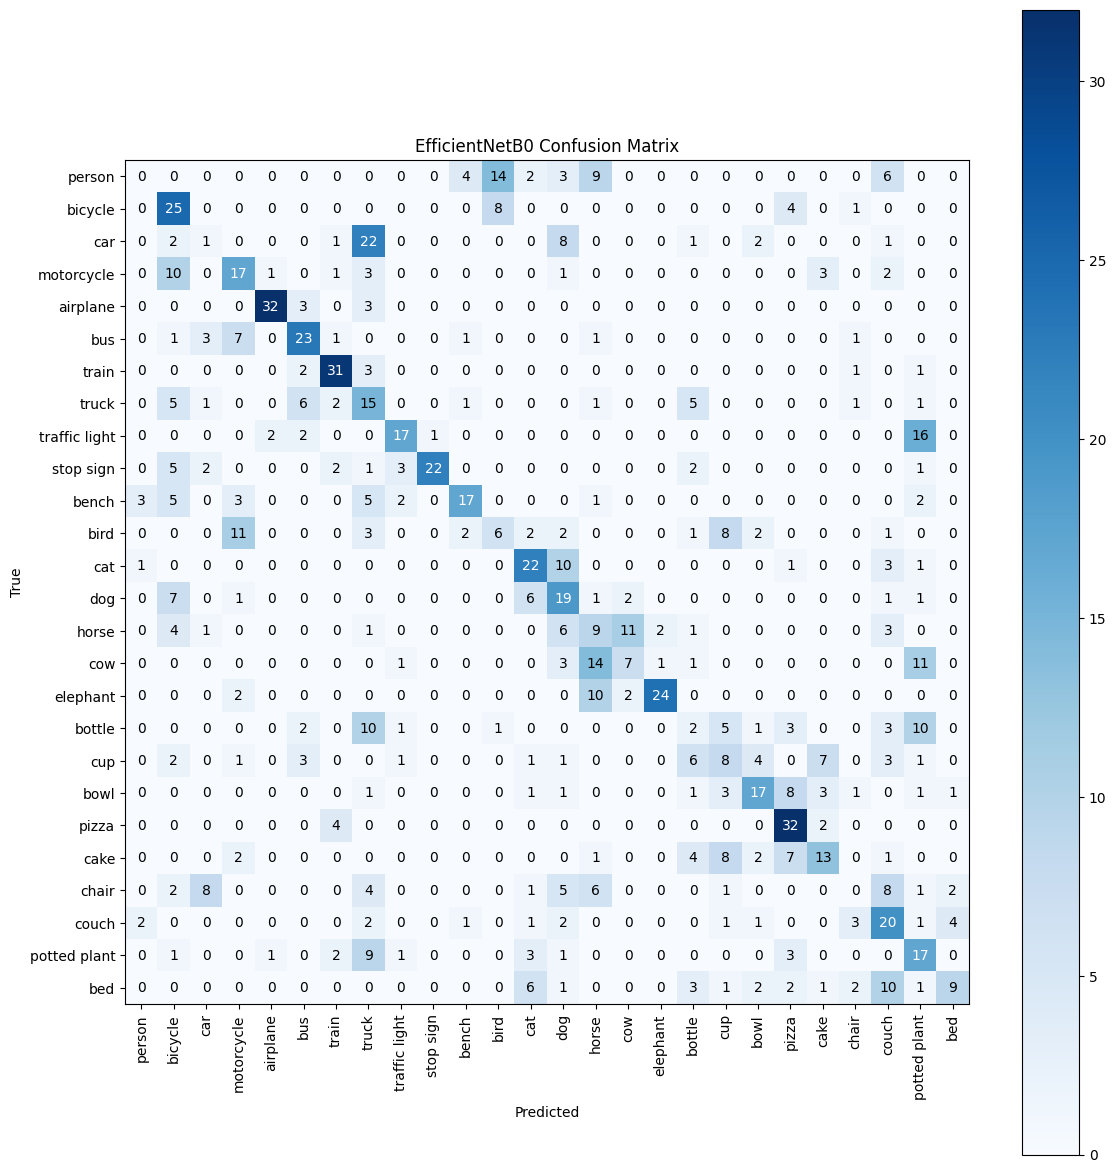

EfficientNetB0 Results: {'model': 'efficientnetb0', 'classification_report': {'person': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 38.0}, 'bicycle': {'precision': 0.36231884057971014, 'recall': 0.6578947368421053, 'f1-score': 0.4672897196261682, 'support': 38.0}, 'car': {'precision': 0.0625, 'recall': 0.02631578947368421, 'f1-score': 0.037037037037037035, 'support': 38.0}, 'motorcycle': {'precision': 0.38636363636363635, 'recall': 0.4473684210526316, 'f1-score': 0.4146341463414634, 'support': 38.0}, 'airplane': {'precision': 0.8888888888888888, 'recall': 0.8421052631578947, 'f1-score': 0.8648648648648649, 'support': 38.0}, 'bus': {'precision': 0.5609756097560976, 'recall': 0.6052631578947368, 'f1-score': 0.5822784810126582, 'support': 38.0}, 'train': {'precision': 0.7045454545454546, 'recall': 0.8157894736842105, 'f1-score': 0.7560975609756098, 'support': 38.0}, 'truck': {'precision': 0.18292682926829268, 'recall': 0.39473684210526316, 'f1-score': 0.25, 'support': 38

79563

In [9]:
# EfficientNetB0
effnet = build_efficientnetb0()
train_model(effnet, "efficientnetb0", epochs=30)
res_eff = evaluate_model(effnet, test_ds, CLASS_NAMES, "efficientnetb0")
plot_confusion_matrix(np.array(res_eff["confusion_matrix"]), CLASS_NAMES, "EfficientNetB0 Confusion Matrix")
print("EfficientNetB0 Results:", res_eff)
del effnet; gc.collect()

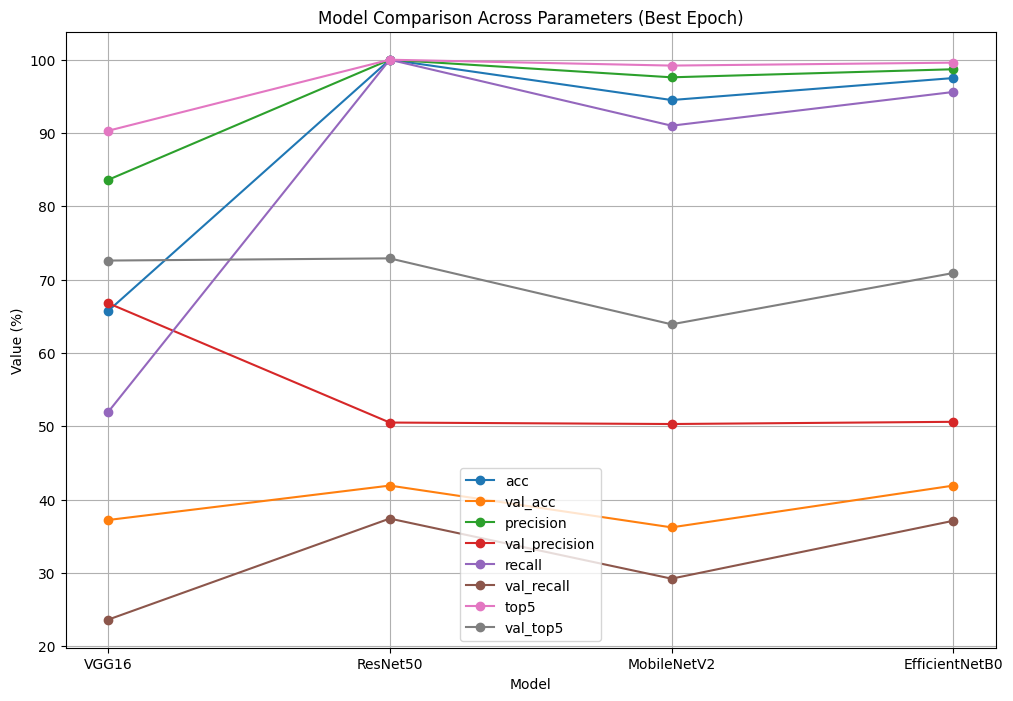

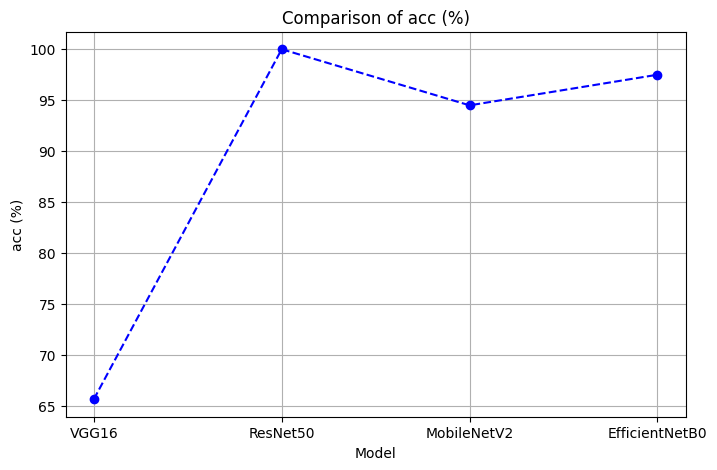

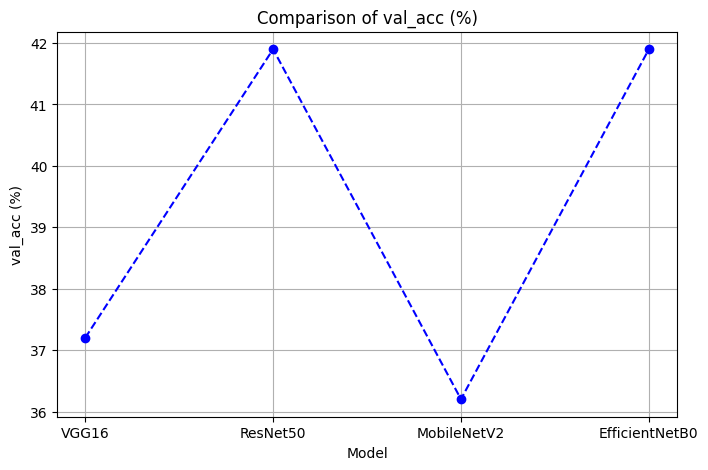

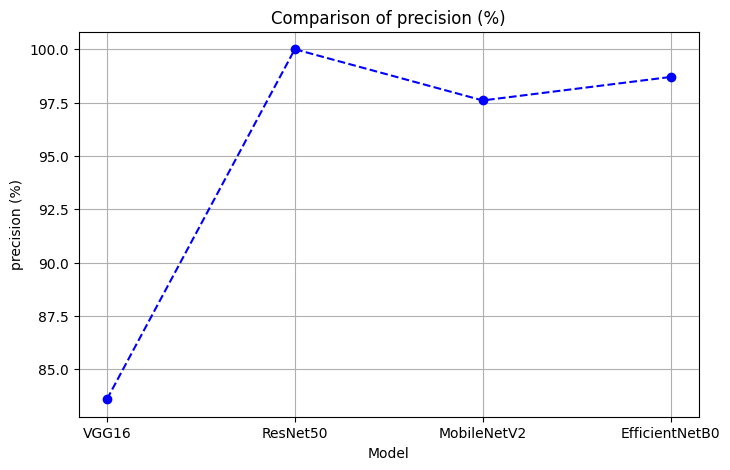

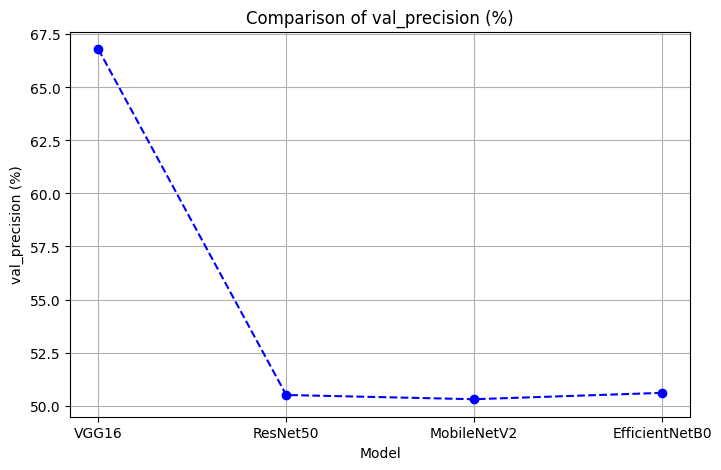

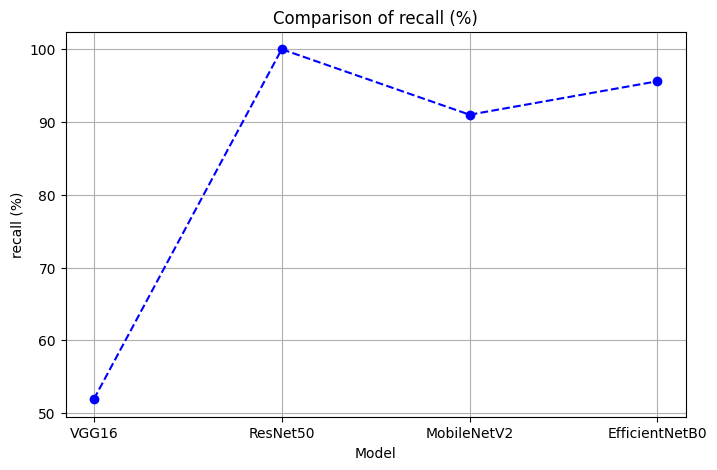

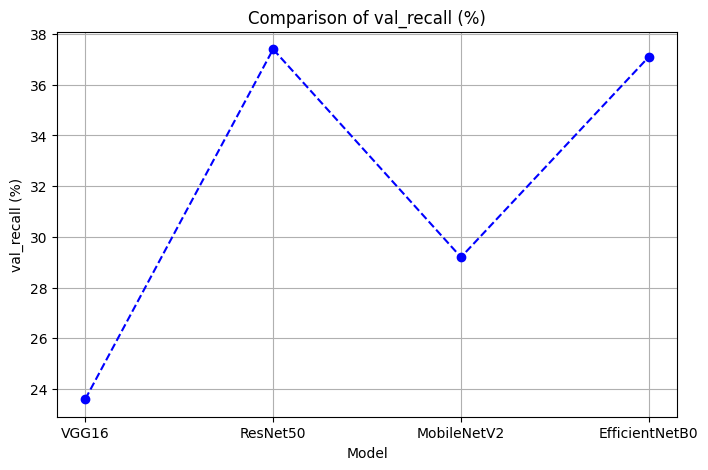

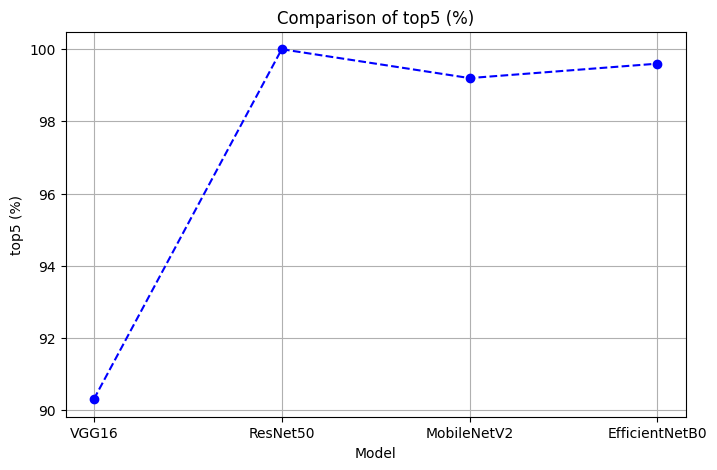

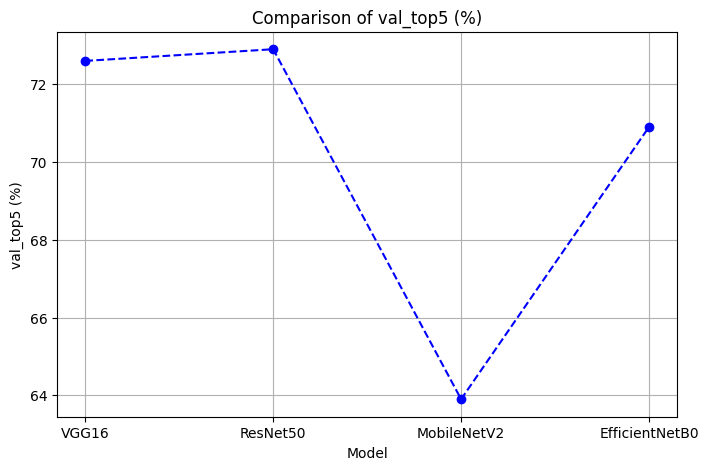

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Best epoch results for each model
results = [
    {"Model": "VGG16", "Epoch": 20, "acc": 65.7, "loss": 1.168, "precision": 83.6, "recall": 51.9,
     "top5": 90.3, "val_acc": 37.2, "val_loss": 2.211, "val_precision": 66.8, "val_recall": 23.6,
     "val_top5": 72.6, "lr": 0.00025},
    {"Model": "ResNet50", "Epoch": 20, "acc": 100.0, "loss": 0.002, "precision": 100.0, "recall": 100.0,
     "top5": 100.0, "val_acc": 41.9, "val_loss": 2.742, "val_precision": 50.5, "val_recall": 37.4,
     "val_top5": 72.9, "lr": 0.00003125},
    {"Model": "MobileNetV2", "Epoch": 12, "acc": 94.5, "loss": 0.222, "precision": 97.6, "recall": 91.0,
     "top5": 99.2, "val_acc": 36.2, "val_loss": 2.830, "val_precision": 50.3, "val_recall": 29.2,
     "val_top5": 63.9, "lr": 0.00025},
    {"Model": "EfficientNetB0", "Epoch": 14, "acc": 97.5, "loss": 0.122, "precision": 98.7, "recall": 95.6,
     "top5": 99.6, "val_acc": 41.9, "val_loss": 2.603, "val_precision": 50.6, "val_recall": 37.1,
     "val_top5": 70.9, "lr": 0.000075}
]

df = pd.DataFrame(results)

# Parameters to compare
metrics = ["acc", "val_acc", "precision", "val_precision", "recall", "val_recall", "top5", "val_top5"]

# Line chart comparison
plt.figure(figsize=(12,8))
for metric in metrics:
    plt.plot(df["Model"], df[metric], marker="o", label=metric)

plt.title("Model Comparison Across Parameters (Best Epoch)")
plt.xlabel("Model")
plt.ylabel("Value (%)")
plt.legend()
plt.grid(True)
plt.show()

# Separate charts for clarity
for metric in metrics:
    plt.figure(figsize=(8,5))
    plt.plot(df["Model"], df[metric], marker="o", linestyle="--", color="blue")
    plt.title(f"Comparison of {metric} (%)")
    plt.xlabel("Model")
    plt.ylabel(f"{metric} (%)")
    plt.grid(True)
    plt.show()

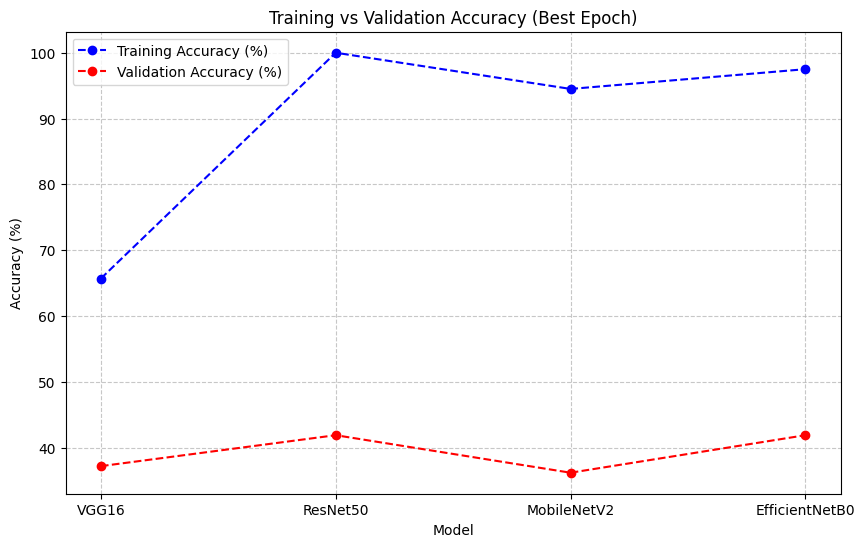

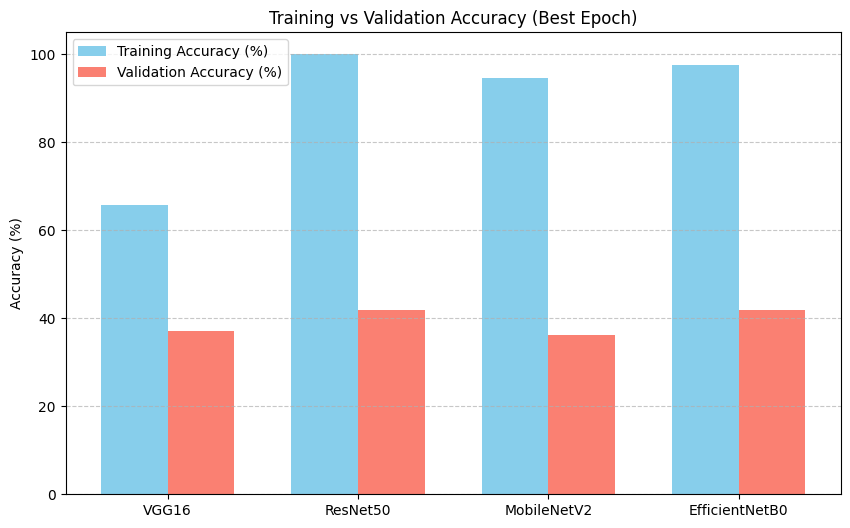

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Accuracy data (best epochs)
results = [
    {"Model": "VGG16", "Train_Acc": 65.7, "Val_Acc": 37.2},
    {"Model": "ResNet50", "Train_Acc": 100.0, "Val_Acc": 41.9},
    {"Model": "MobileNetV2", "Train_Acc": 94.5, "Val_Acc": 36.2},
    {"Model": "EfficientNetB0", "Train_Acc": 97.5, "Val_Acc": 41.9},
]

df = pd.DataFrame(results)

# Line chart for Training vs Validation Accuracy
plt.figure(figsize=(10,6))

plt.plot(df["Model"], df["Train_Acc"], marker="o", linestyle="--", color="blue", label="Training Accuracy (%)")
plt.plot(df["Model"], df["Val_Acc"], marker="o", linestyle="--", color="red", label="Validation Accuracy (%)")

plt.title("Training vs Validation Accuracy (Best Epoch)")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Plot grouped bar chart for accuracy
plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(df))

plt.bar(x, df["Train_Acc"], width=bar_width, label="Training Accuracy (%)", color="skyblue")
plt.bar([i + bar_width for i in x], df["Val_Acc"], width=bar_width, label="Validation Accuracy (%)", color="salmon")

plt.xticks([i + bar_width/2 for i in x], df["Model"])
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy (Best Epoch)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()